In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import os

path = "/home/marta/Documenti/eeg-ml-thesis/"
os.chdir(path)


In [3]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.grid": True,         # Enable grid
    "grid.color": "gray",  # Set grid color to light gray
    "grid.linestyle": "--",     # Set grid line style to dashed
    "grid.linewidth": 0.5,      # Set grid line width
    "figure.facecolor": "#fbfbfb",
    "axes.facecolor": "#fbfbfb",
    "axes.labelsize": 12,  # Increase label size
    "xtick.labelsize": 10,  # Increase tick size
    "ytick.labelsize": 10,  # Increase tick size
    "legend.fontsize": 10   # Improve legend readability
}

sns.set_theme(style="ticks", rc=custom_params)

In [4]:
import os
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm  # Progress bar

# Paths
raw_data_folder = "/home/marta/Documenti/data-milt-preprocessed/train_w1000_ovr0_A_vs_F_vs_C" 
pca_data_folder = "/home/marta/Documenti/data-milt-preprocessed/train_w1000_ovr0_pca50_A_vs_F_vs_C"  
metadata_df = pd.read_csv("/home/marta/Documenti/milt_dataset/datatset/participants.tsv", sep="\t")

def eeg_data_generator(folder_path, metadata_df, batch_size=50):
    files = [f for f in os.listdir(folder_path) if f.endswith(".npz")]
    
    for i in tqdm(range(0, len(files), batch_size), desc="Processing EEG Batches"):
        batch_files = files[i:i + batch_size]
        eeg_batch = []
        subjects = []
        
        for file in batch_files:
            subject_id = file.split("_")[0]  
            data = np.load(os.path.join(folder_path, file), allow_pickle=True)
            eeg_batch.append(data['x_data'])  
            subjects.append(subject_id)

        eeg_batch = np.array(eeg_batch)
        eeg_batch = eeg_batch.reshape(eeg_batch.shape[0], -1)
        df_eeg = pd.DataFrame(eeg_batch)
        df_eeg['participant_id'] = subjects

        
        df_merged = df_eeg.merge(metadata_df, left_on="participant_id", right_on="participant_id", how="inner")
        yield df_merged


In [5]:
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)

umap_embeddings = []
labels_list = []
sexes_list = []
ages_list = []
mmse_list = []
participant_id = []
scaler = StandardScaler()


num_batches = len(os.listdir(pca_data_folder)) // 50 + 1

for batch in tqdm(eeg_data_generator(pca_data_folder, metadata_df, batch_size=50), total=num_batches, desc="Applying UMAP"):
    meta_columns = ['participant_id', 'Age', 'Gender', 'MMSE', 'Group']
    eeg_features = batch.drop(columns=meta_columns).values 
    
    eeg_features_scaled = scaler.fit_transform(eeg_features)

    umap_embeddings_batch = umap_model.fit_transform(eeg_features_scaled)
    umap_embeddings.append(umap_embeddings_batch)

    labels_list.extend(batch['Group'].values)
    sexes_list.extend(batch['Gender'].values)
    ages_list.extend(batch['Age'].values)
    mmse_list.extend(batch['MMSE'].values)
    participant_id.extend(batch['participant_id'].values)


# Convert embeddings to DataFrame
umap_embeddings = np.vstack(umap_embeddings)



Applying UMAP:   0%|          | 0/624 [00:00<?, ?it/s]/home/marta/Documenti/eeg-ml-thesis/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Applying UMAP: 100%|██████████| 624/624 [06:32<00:00,  1.59it/s]


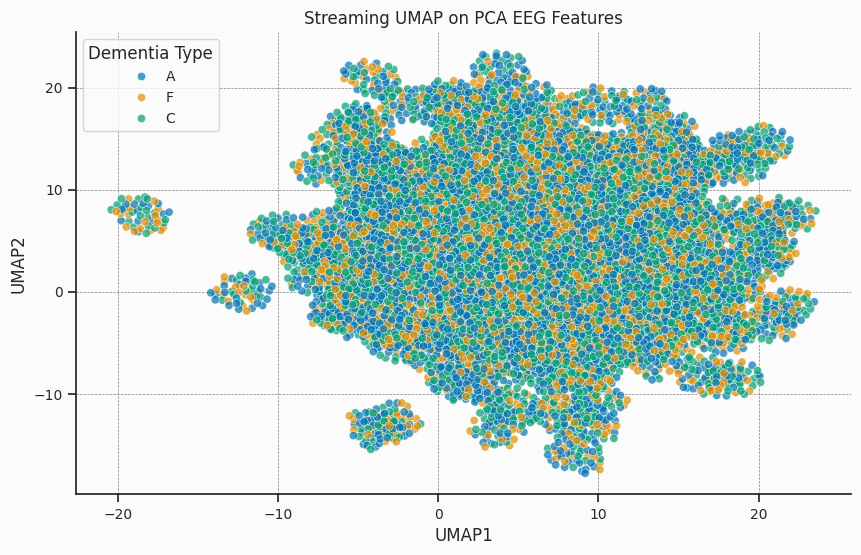

In [6]:
df_umap = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])
df_umap['Group'] = labels_list
df_umap['Gender'] = sexes_list
df_umap['Age'] = ages_list
df_umap['MMSE'] = mmse_list
df_umap['participant_id'] = participant_id
df_umap.head()

def plot_umap(df_umap, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='UMAP1', y='UMAP2', hue='Group', data=df_umap, palette='colorblind', alpha=0.7)
    plt.title(title)
    plt.legend(title='Dementia Type')
    plt.show()

# Visualize UMAP embeddings
plot_umap(df_umap, 'Streaming UMAP on PCA EEG Features')

Applying UMAP:   0%|          | 0/624 [00:00<?, ?it/s]/home/marta/Documenti/eeg-ml-thesis/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Applying UMAP: 100%|██████████| 624/624 [10:05<00:00,  1.03it/s]


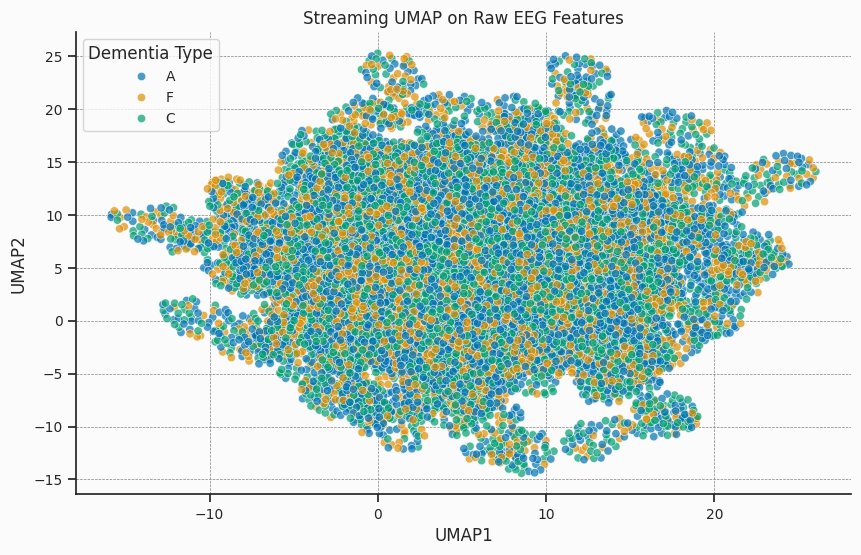

In [7]:
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)

umap_embeddings = []
labels_list = []
sexes_list = []
ages_list = []
mmse_list = []
participant_id = []
scaler = StandardScaler()


num_batches = len(os.listdir(pca_data_folder)) // 50 + 1

for batch in tqdm(eeg_data_generator(raw_data_folder, metadata_df, batch_size=50), total=num_batches, desc="Applying UMAP"):
    meta_columns = ['participant_id', 'Age', 'Gender', 'MMSE', 'Group']
    eeg_features = batch.drop(columns=meta_columns).values 
    
    eeg_features_scaled = scaler.fit_transform(eeg_features)

    umap_embeddings_batch = umap_model.fit_transform(eeg_features_scaled)
    umap_embeddings.append(umap_embeddings_batch)

    labels_list.extend(batch['Group'].values)
    sexes_list.extend(batch['Gender'].values)
    ages_list.extend(batch['Age'].values)
    mmse_list.extend(batch['MMSE'].values)
    participant_id.extend(batch['participant_id'].values)


umap_embeddings = np.vstack(umap_embeddings)

df_umap = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])
df_umap['Group'] = labels_list
df_umap['Gender'] = sexes_list
df_umap['Age'] = ages_list
df_umap['MMSE'] = mmse_list
df_umap['participant_id'] = participant_id
df_umap.head()

def plot_umap(df_umap, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='UMAP1', y='UMAP2', hue='Group', data=df_umap, palette='colorblind', alpha=0.7)
    plt.title(title)
    plt.legend(title='Dementia Type')
    plt.show()

# Visualize UMAP embeddings
plot_umap(df_umap, 'Streaming UMAP on Raw EEG Features')


In [13]:
for file in os.listdir("output-milt/"):
    if not file.startswith("report"):
        continue

    print(f"\nmodello versione {file}\n")
    df_res = pd.read_csv(f"output-milt/{file}")
    print(f"{df_res.head()}")


modello versione report_w1000_ovr250_pca50_seed42_A_vs_C

     Unnamed: 0  precision    recall  f1-score      support
0             0   0.622210  0.541003  0.578772  4329.000000
1             1   0.516898  0.599211  0.555019  3548.000000
2      accuracy   0.567221  0.567221  0.567221     0.567221
3     macro avg   0.569554  0.570107  0.566895  7877.000000
4  weighted avg   0.574775  0.567221  0.568073  7877.000000

modello versione report_w1000_ovr250_pca50_seed42_A_vs_F_vs_C

  Unnamed: 0  precision    recall  f1-score       support
0          0   0.704158  0.860656  0.774581   4270.000000
1          1   0.501538  0.256289  0.339230   2544.000000
2          2   0.817618  0.885067  0.850007   3576.000000
3   accuracy   0.721078  0.721078  0.721078      0.721078
4  macro avg   0.674438  0.667337  0.654606  10390.000000

modello versione report_w1000_ovr250_pca50_seed42_F_vs_C

     Unnamed: 0  precision    recall  f1-score      support
0             0   0.867681  0.954077  0.908831  23

In [14]:
test_df = pd.read_csv("config/test_w1000_ovr0_A_vs_F_vs_C.csv")

In [16]:
test_df['subject'].unique()

array(['sub-048', 'sub-051', 'sub-055', 'sub-068', 'sub-008', 'sub-080',
       'sub-021', 'sub-029', 'sub-015'], dtype=object)